# Import Libraries

#S6F3
Target:
1.  Display 25 misclassified images
2. plots for validation loss and validation accuracy


Analysis:
1. GBN+L1+L2 results in very heavy regularization. Thus it results in model underfit. Using regularization one thing can be said that model will is not overfitting.
2. GBN and BN+L2 performs equally well. These are the best regularizations for our model.
3. In the case of GBN+L1+L2 does not perform well. This is due to huge regularization, because regularization penalizes higher order polynomial and the model moves towards high bias (underfit).


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Ghost Batch Normalization Class

In [7]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
       # print(input.shape) 
        N, C, H, W = input.shape # N is minibatch or batch size
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits , H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [ ]:
# def GhostBatchNorm(X, groupsM, eps=1e-05):
#   """
#   X: Input Tensor with (M, C, F) dimensions
#   groupsM: Number of groups for the mini-batch dimension
#   eps: A small value to prevent division by zero
#   """
#   # Split the mini-batch dimension into groups of smaller batches
#   M, C, F = X.shape
#   print(X.shape())
#   X = X.reshape(groupsM, -1, C, F)
#   # Calculate statistics over dim(0) x dim(2) number
#   # of slices of dim(1) x dim(3) dimension each
#   mean = X.mean([1, 3], keepdim=True)
#   var = X.var([1, 3], unbiased=False, keepdim=True)
#   # Normalize X
#   X = (X - mean) / (torch.sqrt(var + self.eps))
#   # Reshape into the initial tensor shape
#   X = X.reshape(M, C, F)
#   return X

# The model -With BN
Let's start with the model we first saw

In [8]:
import torch.nn.functional as F
dropout_value = 0

class Net(nn.Module):
    def __init__(self,isgbn, nsplit):
        super(Net, self).__init__()
        self.isgbn = isgbn
        self.nsplit = nsplit
        # Input Block

            #
        if self.isgbn:
          self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          GhostBatchNorm(12,self.nsplit))
        else:
          self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(), 
          nn.BatchNorm2d(12))

           # nn.Dropout(dropout_value)
         # output_size = 26

        # CONVOLUTION BLOCK 1
        # self.convblock2 = nn.Sequential(
        #     nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
            
        if self.isgbn:
          self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          GhostBatchNorm(16,self.nsplit))
        else:
          self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16))
            
            #nn.BatchNorm2d(16),
           # nn.Dropout(dropout_value)
        #) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
            
        if self.isgbn:
          self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          GhostBatchNorm(16,self.nsplit))
        else:
          self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16) )             
        #nn.BatchNorm2d(16),
           # nn.Dropout(dropout_value)
        #) # output_size = 10
        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),            
        if self.isgbn:
          self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(), 
          GhostBatchNorm(16,self.nsplit))
        else:
          self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(), 
          nn.BatchNorm2d(16))
               #nn.BatchNorm2d(16),
           # nn.Dropout(dropout_value)
        #) # output_size = 8
        # self.convblock6 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),            
        if self.isgbn:
          self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),     
          GhostBatchNorm(12,self.nsplit))
        else:
          self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
          nn.ReLU(),     
          nn.BatchNorm2d(12))
            #nn.BatchNorm2d(12),
           # nn.Dropout(dropout_value)
        #) # output_size = 6
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        if self.isgbn:
          self.convblock7 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
          nn.ReLU(),
          GhostBatchNorm(12,self.nsplit))
        else:
          self.convblock7 = nn.Sequential(
          nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(12))
            #nn.BatchNorm2d(12),
           # nn.Dropout(dropout_value)
        #) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model1 - With BN + L1
 

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(True,2).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
    GhostBatchNorm-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 16, 24, 24]           1,728
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 12, 24, 24]             192
         MaxPool2d-8           [-1, 12, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,728
             ReLU-10           [-1, 16, 10, 10]               0
   GhostBatchNorm-11           [-1, 16, 10, 10]              32
           Conv2d-12             [-1, 16, 8, 8]           2,304
             ReLU-13             [-1, 16, 8, 8]               0
   GhostBatchNorm-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_regularization=0, l2_regularization=0):
  l1_loss =0 
  l2_loss =0
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    # Computing L1 and L2 losses
    if l1_regularization > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param, 1)
      loss += l1_regularization * l1_loss
    if l2_regularization > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param, 2)
      loss += l2_regularization * l2_loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

   # pbar_str = f'Loss={loss.item()} l1_loss={l1_loss.item()} l2_loss={l2_loss.item()}'
    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    pbar.set_description(desc= f'Loss={loss.item()} l1_loss={l1_loss} l2_loss={l2_loss} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, missed_images, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              incorrect_pred_indices = (is_correct==0).nonzero()[:,0]
              for incorrect_ind in incorrect_pred_indices:
                if len(missed_images) == 25:
                  break
                missed_images.append({
                    'target': target[incorrect_ind].cpu().numpy(),
                    'pred': pred[incorrect_ind][0].cpu().numpy(),
                    'img': data[incorrect_ind].cpu().numpy()[0]
                })                
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTesting Results: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [11]:
from torch.optim.lr_scheduler import StepLR
def runDifferentRegularization(l1_regularization, l2_regularization,isGBN= False, nNumSplits=1):
  model = Net(isGBN, nNumSplits).to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  scheduler = StepLR(optimizer, step_size=4, gamma=0.01)
  EPOCHS = 25
  test_losses=[]
  missed_images = []
  test_acc=[]
  for epoch in range(EPOCHS):
    print('\n EPOCH:', epoch, '  GBN:', isGBN, '  L1 norm:', l1_regularization,'  L2 norm:', l2_regularization )
    train(model, device, train_loader, optimizer, epoch, l1_regularization, l2_regularization)
    scheduler.step()
    test(model, device,test_loader, test_losses, test_acc, missed_images, epoch==EPOCHS-1)
  return test_losses, test_acc, missed_images

# 1. Call Train and Test functions
# 2. Print mis-classified images

  0%|          | 0/469 [00:00<?, ?it/s]


 EPOCH: 0   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.05706310272216797 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=92.52: 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0588, Accuracy: 9823/10000 (98.23%)


 EPOCH: 1   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.05360959842801094 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:19<00:00, 24.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0353, Accuracy: 9886/10000 (98.86%)


 EPOCH: 2   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.07433459907770157 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0386, Accuracy: 9872/10000 (98.72%)


 EPOCH: 3   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.031248897314071655 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:19<00:00, 24.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0312, Accuracy: 9895/10000 (98.95%)


 EPOCH: 4   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.08695680648088455 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)


 EPOCH: 5   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.0040368628688156605 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:19<00:00, 24.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)


 EPOCH: 6   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.0236057098954916 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)


 EPOCH: 7   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.031938500702381134 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:19<00:00, 23.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)


 EPOCH: 8   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.025541305541992188 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)


 EPOCH: 9   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.027013540267944336 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)


 EPOCH: 10   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.03714849054813385 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)


 EPOCH: 11   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.058580175042152405 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)


 EPOCH: 12   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.017984507605433464 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)


 EPOCH: 13   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.014422789216041565 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)


 EPOCH: 14   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.043088916689157486 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0195, Accuracy: 9938/10000 (99.38%)


 EPOCH: 15   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.023599257692694664 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)


 EPOCH: 16   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.10618647187948227 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)


 EPOCH: 17   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.04910193011164665 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)


 EPOCH: 18   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.022170284762978554 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)


 EPOCH: 19   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.025188013911247253 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)


 EPOCH: 20   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.2515711486339569 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)


 EPOCH: 21   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.05360240861773491 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)


 EPOCH: 22   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.042284440249204636 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)


 EPOCH: 23   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.027774741873145103 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)


 EPOCH: 24   GBN: True   L1 norm: 0.0   L2 norm: 0.0


Loss=0.032225705683231354 l1_loss=0 l2_loss=0 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



Testing Results: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]


 EPOCH: 0   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=1.121699571609497 l1_loss=134.66586303710938 l2_loss=21.3389892578125 Batch_id=468 Accuracy=87.12: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.3486, Accuracy: 9001/10000 (90.01%)


 EPOCH: 1   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=1.0439509153366089 l1_loss=127.72753143310547 l2_loss=21.375900268554688 Batch_id=468 Accuracy=91.18: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.2367, Accuracy: 9341/10000 (93.41%)


 EPOCH: 2   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=1.1180006265640259 l1_loss=127.28741455078125 l2_loss=21.63728141784668 Batch_id=468 Accuracy=91.09: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.8009, Accuracy: 7329/10000 (73.29%)


 EPOCH: 3   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=1.0175725221633911 l1_loss=117.44374084472656 l2_loss=21.34105682373047 Batch_id=468 Accuracy=91.48: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.3167, Accuracy: 8997/10000 (89.97%)


 EPOCH: 4   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.8491718769073486 l1_loss=99.93663024902344 l2_loss=20.89859390258789 Batch_id=468 Accuracy=93.94: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0789, Accuracy: 9773/10000 (97.73%)


 EPOCH: 5   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7380588054656982 l1_loss=92.88626098632812 l2_loss=20.493785858154297 Batch_id=468 Accuracy=94.85: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0738, Accuracy: 9790/10000 (97.90%)


 EPOCH: 6   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.8175302743911743 l1_loss=87.90287017822266 l2_loss=20.11932945251465 Batch_id=468 Accuracy=95.14: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0738, Accuracy: 9789/10000 (97.89%)


 EPOCH: 7   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.705509603023529 l1_loss=84.11865997314453 l2_loss=19.77049446105957 Batch_id=468 Accuracy=95.19: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0743, Accuracy: 9796/10000 (97.96%)


 EPOCH: 8   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7441692352294922 l1_loss=83.94258117675781 l2_loss=19.766530990600586 Batch_id=468 Accuracy=95.22: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0716, Accuracy: 9796/10000 (97.96%)


 EPOCH: 9   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7124673128128052 l1_loss=83.87384796142578 l2_loss=19.763286590576172 Batch_id=468 Accuracy=95.26: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0713, Accuracy: 9799/10000 (97.99%)


 EPOCH: 10   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.712019145488739 l1_loss=83.8156967163086 l2_loss=19.760164260864258 Batch_id=468 Accuracy=95.40: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0707, Accuracy: 9795/10000 (97.95%)


 EPOCH: 11   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7592540383338928 l1_loss=83.76345825195312 l2_loss=19.75708770751953 Batch_id=468 Accuracy=95.29: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0718, Accuracy: 9797/10000 (97.97%)


 EPOCH: 12   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.8732487559318542 l1_loss=83.76179504394531 l2_loss=19.75706672668457 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:19<00:00, 23.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0708, Accuracy: 9799/10000 (97.99%)


 EPOCH: 13   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7573126554489136 l1_loss=83.76119995117188 l2_loss=19.757051467895508 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0713, Accuracy: 9796/10000 (97.96%)


 EPOCH: 14   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6380912661552429 l1_loss=83.76063537597656 l2_loss=19.757034301757812 Batch_id=468 Accuracy=95.40: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0708, Accuracy: 9798/10000 (97.98%)


 EPOCH: 15   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7149375081062317 l1_loss=83.76008605957031 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.42: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0702, Accuracy: 9802/10000 (98.02%)


 EPOCH: 16   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6921844482421875 l1_loss=83.76007080078125 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.39: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0712, Accuracy: 9794/10000 (97.94%)


 EPOCH: 17   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6488115191459656 l1_loss=83.76007080078125 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0717, Accuracy: 9797/10000 (97.97%)


 EPOCH: 18   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.669967532157898 l1_loss=83.76007080078125 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.40: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0709, Accuracy: 9797/10000 (97.97%)


 EPOCH: 19   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7636602520942688 l1_loss=83.76005554199219 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.37: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0707, Accuracy: 9797/10000 (97.97%)


 EPOCH: 20   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7030531764030457 l1_loss=83.76005554199219 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0708, Accuracy: 9802/10000 (98.02%)


 EPOCH: 21   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6836196780204773 l1_loss=83.76005554199219 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.39: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0710, Accuracy: 9799/10000 (97.99%)


 EPOCH: 22   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.7245063185691833 l1_loss=83.76005554199219 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0707, Accuracy: 9799/10000 (97.99%)


 EPOCH: 23   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5766805410385132 l1_loss=83.76005554199219 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.42: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0708, Accuracy: 9801/10000 (98.01%)


 EPOCH: 24   GBN: True   L1 norm: 0.005   L2 norm: 0.005


Loss=0.722538948059082 l1_loss=83.76005554199219 l2_loss=19.75701904296875 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]



Testing Results: Average loss: 0.0712, Accuracy: 9792/10000 (97.92%)



  0%|          | 0/469 [00:00<?, ?it/s]


 EPOCH: 0   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.8356336355209351 l1_loss=137.7684326171875 l2_loss=0 Batch_id=468 Accuracy=90.18: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.2747, Accuracy: 9246/10000 (92.46%)


 EPOCH: 1   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.8621082901954651 l1_loss=124.4272689819336 l2_loss=0 Batch_id=468 Accuracy=93.36: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.2751, Accuracy: 9178/10000 (91.78%)


 EPOCH: 2   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.7987903952598572 l1_loss=117.75747680664062 l2_loss=0 Batch_id=468 Accuracy=93.55: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.7273, Accuracy: 7467/10000 (74.67%)


 EPOCH: 3   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.8694159984588623 l1_loss=118.24065399169922 l2_loss=0 Batch_id=468 Accuracy=93.70: 100%|██████████| 469/469 [00:18<00:00, 25.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.6032, Accuracy: 7786/10000 (77.86%)


 EPOCH: 4   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.6980510950088501 l1_loss=99.5859603881836 l2_loss=0 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0705, Accuracy: 9809/10000 (98.09%)


 EPOCH: 5   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.6041704416275024 l1_loss=92.0823745727539 l2_loss=0 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0646, Accuracy: 9834/10000 (98.34%)


 EPOCH: 6   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.6317111849784851 l1_loss=86.89231872558594 l2_loss=0 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0643, Accuracy: 9828/10000 (98.28%)


 EPOCH: 7   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.4851391911506653 l1_loss=83.12345886230469 l2_loss=0 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0642, Accuracy: 9830/10000 (98.30%)


 EPOCH: 8   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5518468022346497 l1_loss=82.93838500976562 l2_loss=0 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0625, Accuracy: 9835/10000 (98.35%)


 EPOCH: 9   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5096552968025208 l1_loss=82.86046600341797 l2_loss=0 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0616, Accuracy: 9840/10000 (98.40%)


 EPOCH: 10   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.46888911724090576 l1_loss=82.79398345947266 l2_loss=0 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0622, Accuracy: 9839/10000 (98.39%)


 EPOCH: 11   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5029412508010864 l1_loss=82.73544311523438 l2_loss=0 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0608, Accuracy: 9842/10000 (98.42%)


 EPOCH: 12   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.4978371858596802 l1_loss=82.73368072509766 l2_loss=0 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0622, Accuracy: 9842/10000 (98.42%)


 EPOCH: 13   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.4783901870250702 l1_loss=82.73304748535156 l2_loss=0 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0628, Accuracy: 9833/10000 (98.33%)


 EPOCH: 14   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.48540329933166504 l1_loss=82.7324447631836 l2_loss=0 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0612, Accuracy: 9846/10000 (98.46%)


 EPOCH: 15   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5024992227554321 l1_loss=82.73187255859375 l2_loss=0 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:19<00:00, 24.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0613, Accuracy: 9841/10000 (98.41%)


 EPOCH: 16   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.492397665977478 l1_loss=82.73185729980469 l2_loss=0 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0613, Accuracy: 9843/10000 (98.43%)


 EPOCH: 17   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5503948330879211 l1_loss=82.73185729980469 l2_loss=0 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0616, Accuracy: 9838/10000 (98.38%)


 EPOCH: 18   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.481073260307312 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0617, Accuracy: 9836/10000 (98.36%)


 EPOCH: 19   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.4549352824687958 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0605, Accuracy: 9847/10000 (98.47%)


 EPOCH: 20   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.4518085718154907 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0627, Accuracy: 9836/10000 (98.36%)


 EPOCH: 21   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5478835105895996 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0617, Accuracy: 9837/10000 (98.37%)


 EPOCH: 22   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5536808371543884 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0616, Accuracy: 9839/10000 (98.39%)


 EPOCH: 23   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.5120329856872559 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0617, Accuracy: 9835/10000 (98.35%)


 EPOCH: 24   GBN: False   L1 norm: 0.005   L2 norm: 0.0


Loss=0.47289490699768066 l1_loss=82.73184967041016 l2_loss=0 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Testing Results: Average loss: 0.0619, Accuracy: 9838/10000 (98.38%)



  0%|          | 0/469 [00:00<?, ?it/s]


 EPOCH: 0   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.36078941822052 l1_loss=0 l2_loss=52.475528717041016 Batch_id=468 Accuracy=93.23: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.1032, Accuracy: 9702/10000 (97.02%)


 EPOCH: 1   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.34974268078804016 l1_loss=0 l2_loss=48.825035095214844 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.1448, Accuracy: 9557/10000 (95.57%)


 EPOCH: 2   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.3998008966445923 l1_loss=0 l2_loss=47.57332992553711 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.1538, Accuracy: 9511/10000 (95.11%)


 EPOCH: 3   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.31283923983573914 l1_loss=0 l2_loss=45.090518951416016 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 25.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0768, Accuracy: 9768/10000 (97.68%)


 EPOCH: 4   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2702232897281647 l1_loss=0 l2_loss=44.677425384521484 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0299, Accuracy: 9907/10000 (99.07%)


 EPOCH: 5   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.28235459327697754 l1_loss=0 l2_loss=44.215660095214844 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0267, Accuracy: 9921/10000 (99.21%)


 EPOCH: 6   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.25459563732147217 l1_loss=0 l2_loss=43.723731994628906 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0247, Accuracy: 9923/10000 (99.23%)


 EPOCH: 7   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2676926553249359 l1_loss=0 l2_loss=43.20553970336914 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0236, Accuracy: 9937/10000 (99.37%)


 EPOCH: 8   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2924981415271759 l1_loss=0 l2_loss=43.198570251464844 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)


 EPOCH: 9   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2648274004459381 l1_loss=0 l2_loss=43.192710876464844 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0234, Accuracy: 9936/10000 (99.36%)


 EPOCH: 10   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.24307984113693237 l1_loss=0 l2_loss=43.186641693115234 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)


 EPOCH: 11   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2651016414165497 l1_loss=0 l2_loss=43.18048858642578 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0235, Accuracy: 9932/10000 (99.32%)


 EPOCH: 12   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.29700666666030884 l1_loss=0 l2_loss=43.180458068847656 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:18<00:00, 25.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0234, Accuracy: 9932/10000 (99.32%)


 EPOCH: 13   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.24924056231975555 l1_loss=0 l2_loss=43.18043899536133 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)


 EPOCH: 14   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2577003836631775 l1_loss=0 l2_loss=43.180423736572266 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:18<00:00, 24.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0233, Accuracy: 9937/10000 (99.37%)


 EPOCH: 15   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.3049977421760559 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)


 EPOCH: 16   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.24879002571105957 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)


 EPOCH: 17   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.23516982793807983 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0233, Accuracy: 9935/10000 (99.35%)


 EPOCH: 18   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2737663984298706 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0235, Accuracy: 9936/10000 (99.36%)


 EPOCH: 19   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2423933893442154 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0232, Accuracy: 9932/10000 (99.32%)


 EPOCH: 20   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.22875481843948364 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0237, Accuracy: 9936/10000 (99.36%)


 EPOCH: 21   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.25615593791007996 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0234, Accuracy: 9931/10000 (99.31%)


 EPOCH: 22   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.27445757389068604 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0234, Accuracy: 9934/10000 (99.34%)


 EPOCH: 23   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2902100086212158 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)


 EPOCH: 24   GBN: False   L1 norm: 0.0   L2 norm: 0.005


Loss=0.2633333206176758 l1_loss=0 l2_loss=43.18040466308594 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Testing Results: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)



  0%|          | 0/469 [00:00<?, ?it/s]


 EPOCH: 0   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=1.0418596267700195 l1_loss=139.14073181152344 l2_loss=21.21410369873047 Batch_id=468 Accuracy=90.31: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.3167, Accuracy: 9008/10000 (90.08%)


 EPOCH: 1   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.895471453666687 l1_loss=123.0058364868164 l2_loss=20.417932510375977 Batch_id=468 Accuracy=93.65: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 1.6213, Accuracy: 5417/10000 (54.17%)


 EPOCH: 2   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.9690764546394348 l1_loss=122.55037689208984 l2_loss=20.455875396728516 Batch_id=468 Accuracy=93.69: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.2008, Accuracy: 9424/10000 (94.24%)


 EPOCH: 3   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.9563974142074585 l1_loss=120.15869140625 l2_loss=20.512306213378906 Batch_id=468 Accuracy=93.67: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.3533, Accuracy: 8812/10000 (88.12%)


 EPOCH: 4   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6802549362182617 l1_loss=98.68040466308594 l2_loss=19.94901466369629 Batch_id=468 Accuracy=96.41: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0712, Accuracy: 9799/10000 (97.99%)


 EPOCH: 5   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6207124590873718 l1_loss=89.01338195800781 l2_loss=19.42580795288086 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0652, Accuracy: 9811/10000 (98.11%)


 EPOCH: 6   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5811127424240112 l1_loss=82.515380859375 l2_loss=18.93860626220703 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0644, Accuracy: 9809/10000 (98.09%)


 EPOCH: 7   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6000277400016785 l1_loss=77.77030944824219 l2_loss=18.489028930664062 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0630, Accuracy: 9828/10000 (98.28%)


 EPOCH: 8   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5410351157188416 l1_loss=77.56271362304688 l2_loss=18.483322143554688 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0602, Accuracy: 9833/10000 (98.33%)


 EPOCH: 9   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6471017599105835 l1_loss=77.47490692138672 l2_loss=18.47904396057129 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0596, Accuracy: 9833/10000 (98.33%)


 EPOCH: 10   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5786864757537842 l1_loss=77.39851379394531 l2_loss=18.474668502807617 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0597, Accuracy: 9827/10000 (98.27%)


 EPOCH: 11   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5936030745506287 l1_loss=77.33149719238281 l2_loss=18.47029685974121 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0593, Accuracy: 9830/10000 (98.30%)


 EPOCH: 12   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5715621113777161 l1_loss=77.32960510253906 l2_loss=18.470260620117188 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0592, Accuracy: 9834/10000 (98.34%)


 EPOCH: 13   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5752359628677368 l1_loss=77.3288345336914 l2_loss=18.47023582458496 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0581, Accuracy: 9836/10000 (98.36%)


 EPOCH: 14   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5439427495002747 l1_loss=77.3281021118164 l2_loss=18.470211029052734 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0591, Accuracy: 9835/10000 (98.35%)


 EPOCH: 15   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5413641929626465 l1_loss=77.327392578125 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0591, Accuracy: 9835/10000 (98.35%)


 EPOCH: 16   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5358032584190369 l1_loss=77.32737731933594 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0586, Accuracy: 9837/10000 (98.37%)


 EPOCH: 17   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5804302096366882 l1_loss=77.32737731933594 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0594, Accuracy: 9832/10000 (98.32%)


 EPOCH: 18   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5449329614639282 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0590, Accuracy: 9837/10000 (98.37%)


 EPOCH: 19   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5311468839645386 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0591, Accuracy: 9836/10000 (98.36%)


 EPOCH: 20   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5588135719299316 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0594, Accuracy: 9837/10000 (98.37%)


 EPOCH: 21   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.575391411781311 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0591, Accuracy: 9835/10000 (98.35%)


 EPOCH: 22   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5846827030181885 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0590, Accuracy: 9842/10000 (98.42%)


 EPOCH: 23   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.6495540738105774 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Testing Results: Average loss: 0.0590, Accuracy: 9838/10000 (98.38%)


 EPOCH: 24   GBN: False   L1 norm: 0.005   L2 norm: 0.005


Loss=0.5890990495681763 l1_loss=77.3273696899414 l2_loss=18.47018814086914 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]



Testing Results: Average loss: 0.0591, Accuracy: 9830/10000 (98.30%)

5


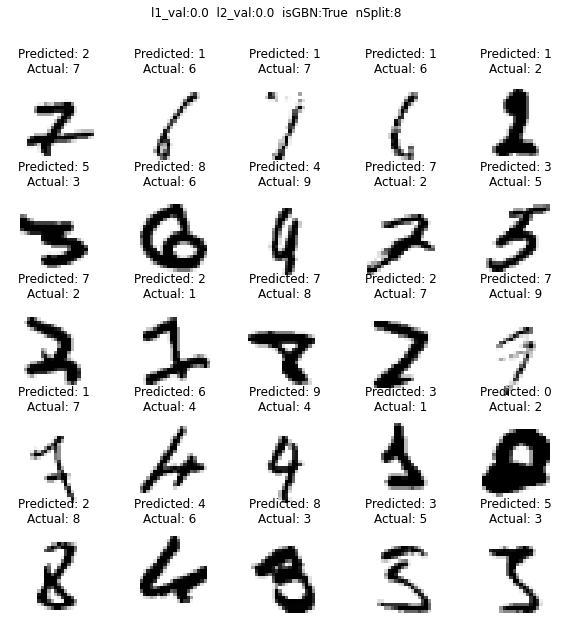

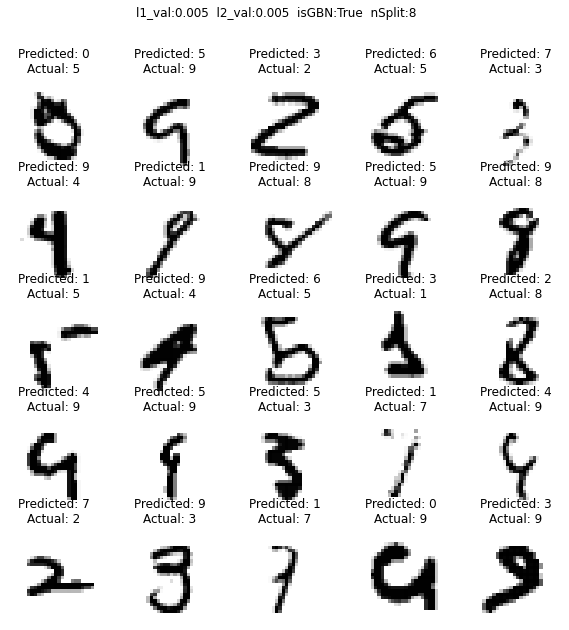

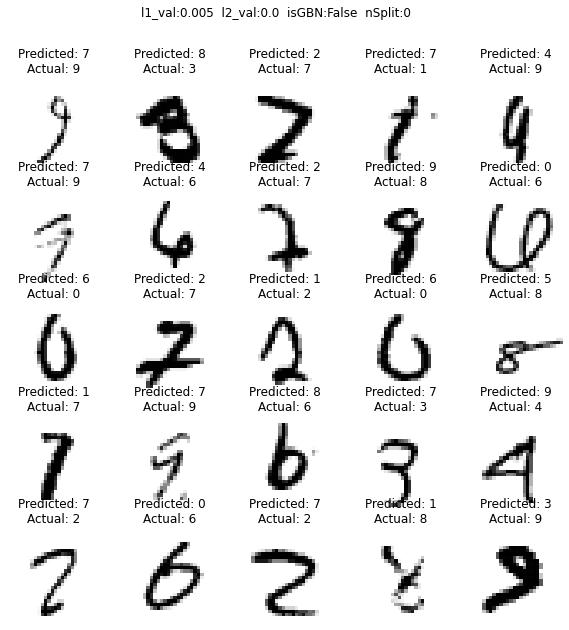

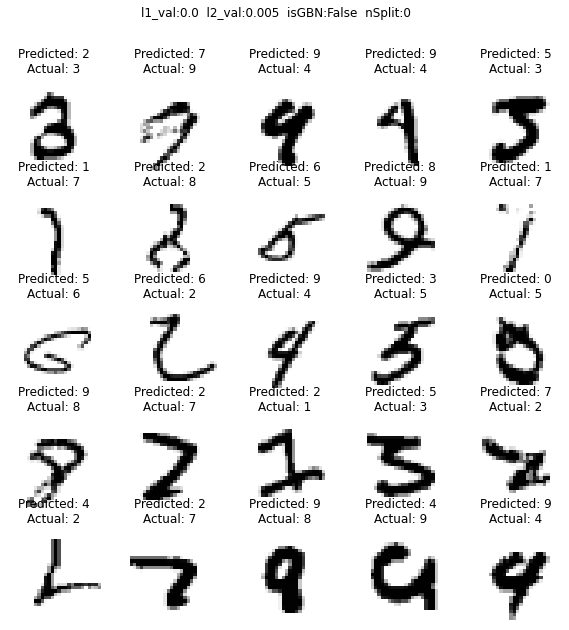

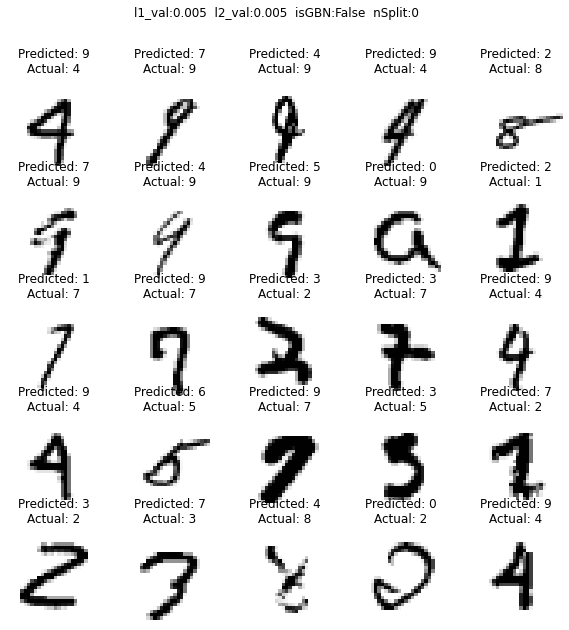

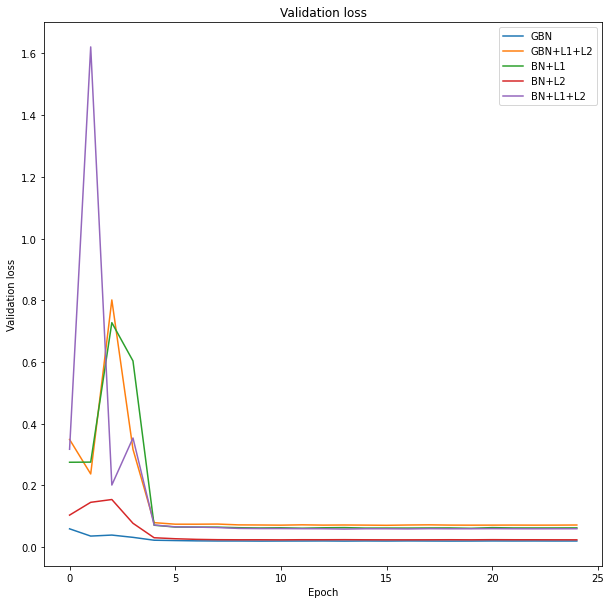

In [12]:
import matplotlib.pyplot as plt
L1_list =[0.0, 0.005, 0.005, 0.0, 0.005] 
L2_list =[0.0, 0.005, 0.0, 0.005, 0.005]
GBN_List = [True,True, False, False, False] 
test_losses_list = []
test_acc_list = [] 
nSplit_List = [8, 8, 0, 0, 0]
for (l1_val, l2_val,isGBN,nSplit) in zip(L1_list, L2_list,GBN_List,nSplit_List):
  test_losses, test_acc, missed_images = runDifferentRegularization(l1_val, l2_val,isGBN,nSplit)
  test_losses_list.append(test_losses)
  test_acc_list.append(test_acc)
  figure = plt.figure(figsize=(10, 10))
  figure.suptitle('l1_val:'+str(l1_val)+'  l2_val:'+str(l2_val)+'  isGBN:'+str(isGBN)+'  nSplit:'+str(nSplit))
  for index in range(1, 26):
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.imshow(missed_images[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (missed_images[index-1]["pred"], missed_images[index-1]["target"]))
  
  
#plot graphs 
fig = plt.figure(figsize=(10, 10))
plt.title(f'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

print(len(test_losses_list))
run_list = ['GBN', 'GBNL1L2', 'BNL1','BNL2', 'BNL1L2']
#for idx, run in enumerate(zip(run_list, run_list)):
#  plt.plot(test_losses_list[idx])
GBN = plt.plot(test_losses_list[0], label = 'GBN')
GBNL1L2 = plt.plot(test_losses_list[1], label = 'GBN+L1+L2')
BNL1 = plt.plot(test_losses_list[2], label = 'BN+L1')
BNL2 = plt.plot(test_losses_list[3], label = 'BN+L2')
BNL1L2 = plt.plot(test_losses_list[4], label = 'BN+L1+L2')
plt.legend()
plt.show()
# plt.legend((GBN, GBNL1L2,BNL1,BNL2,BNL1L2),
#           ('GBN', 'GBN+L1+L2', 'BN+L1','BN+L2', 'BN+L1+L2'))

5


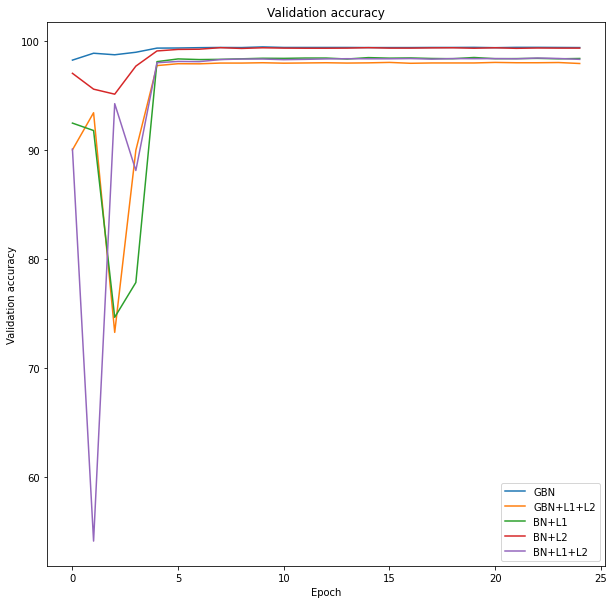

In [13]:
#plot graphs 
fig = plt.figure(figsize=(10, 10))
plt.title(f'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')

print(len(test_acc_list))
run_list = ['GBN', 'GBNL1L2', 'BNL1','BNL2', 'BNL1L2']
GBN = plt.plot(test_acc_list[0], label = 'GBN')
GBNL1L2 = plt.plot(test_acc_list[1], label = 'GBN+L1+L2')
BNL1 = plt.plot(test_acc_list[2], label = 'BN+L1')
BNL2 = plt.plot(test_acc_list[3], label = 'BN+L2')
BNL1L2 = plt.plot(test_acc_list[4], label = 'BN+L1+L2')
plt.legend()
plt.show()

In [ ]:
## from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# #from torch_lr_finder import LRFinder

# model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.7)
# #optimizer = optim.Adam(model.parameters(), lr=0.01)

# scheduler = StepLR(optimizer, step_size=4, gamma=0.01)
# #scheduler = ReduceLROnPlateau(optimizer, 'min',patience = 2)

# EPOCHS = 15
# for epoch in range(EPOCHS):
#     #print("EPOCH:", epoch)
#     print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
#     train(model, device, train_loader, optimizer, epoch)
#     scheduler.step()
#     test(model, device, test_loader)

# Printing mis-classified images


Text(0.5, 1.0, 'Test Accuracy')

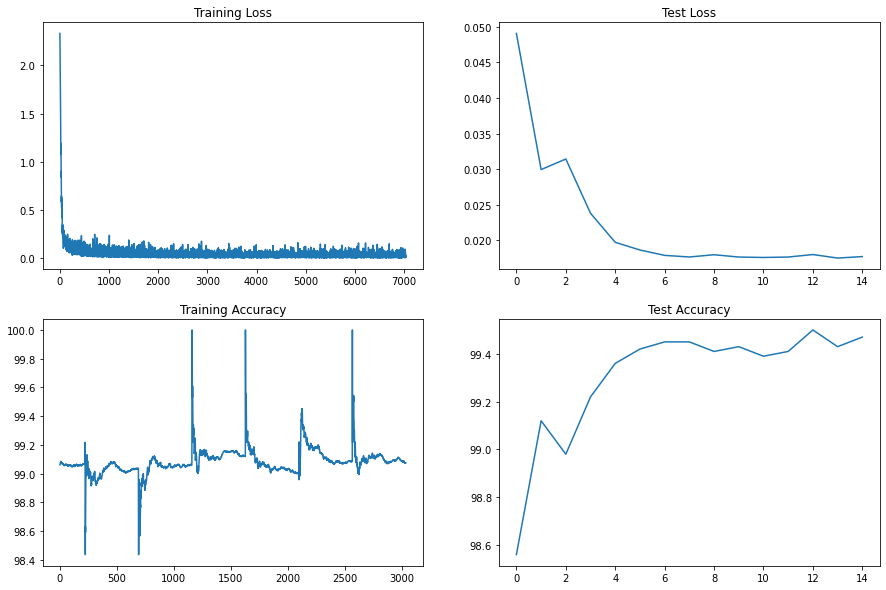

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_acc[4000:])
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_acc)
# axs[1, 1].set_title("Test Accuracy")